In [40]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import sqlite3 
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import SelectFromModel
from scipy.stats import randint
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import joblib

pd.set_option('display.max_columns', None)


In [5]:
db_path = os.path.join('..', 'data', 'database_credito.db')

try:
    conn = sqlite3.connect(db_path)
    print("Conectado a la base de datos con éxito")
except sqlite3.OperationalError as e:
    print(f"Error al abrir la base de datos: {e}")

Conectado a la base de datos con éxito


In [6]:

data_modelar_red = pd.read_sql('SELECT * FROM Data_Red_modelar', conn)
conn.close()

In [7]:
data_modelar_red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90528 entries, 0 to 90527
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Mezcla_Credito_Ordinal        90528 non-null  float64
 1   Pago_Monto_Minimo_f           90528 non-null  int64  
 2   Tasa_Interes                  90528 non-null  int64  
 3   Retraso_Promedio_Pagos        90528 non-null  int64  
 4   Numero_Consultas_Credito      90528 non-null  float64
 5   Deuda_Pendiente               90528 non-null  float64
 6   Antiguedad_Historial_Credito  90528 non-null  float64
 7   Numero_Tarjetas_Credito       90528 non-null  int64  
 8   Numero_Cuentas_Bancarias      90528 non-null  int64  
 9   Suma_Q_prestamos              90528 non-null  int64  
 10  Puntaje_Credito               90528 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 7.6 MB


Hacemos el split de datos conservando el random state para repetibilidad 

In [8]:
X = data_modelar_red.drop('Puntaje_Credito', axis=1)
y = data_modelar_red['Puntaje_Credito']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Entrenamos el modelo con valores de default

In [9]:
model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)

model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [10]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8494421738650171
Matriz de Confusión:
[[5232  580  298]
 [ 740 4712  568]
 [  74  466 5436]]
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      6110
           1       0.82      0.78      0.80      6020
           2       0.86      0.91      0.89      5976

    accuracy                           0.85     18106
   macro avg       0.85      0.85      0.85     18106
weighted avg       0.85      0.85      0.85     18106



In [11]:

pipeline = Pipeline([
    ('classifier', RandomForestClassifier(random_state=42))
])


In [12]:
param_dist = {
    'classifier__n_estimators': randint(10, 1000),
    'classifier__max_depth': [None] + list(randint(10, 50).rvs(10)),
    'classifier__min_samples_split': randint(2, 20), 
    'classifier__min_samples_leaf': randint(1, 20),
    'classifier__bootstrap': [True, False]
}

In [13]:
random_search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_dist, 
    n_iter=50,
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

In [14]:

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('classifier',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'classifier__bootstrap': [True, False],
                                        'classifier__max_depth': [None, 33, 12,
                                                                  33, 49, 11,
                                                                  40, 27, 40,
                                                                  37, 33],
                                        'classifier__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001B1E0EF4E30>,
                                        'classifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001B1DE6D0230>,
                                        'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001B1E0EF1820>},
                   random_state=42, verbose=1)

In [18]:
print(f"Mejor puntaje de validación: {random_search.best_score_:.4f}")

print(f"Mejores hiperparámetros: {random_search.best_params_}")

best_model = random_search.best_estimator_
print(f"Mejor modelo: {best_model}")

results = pd.DataFrame(random_search.cv_results_)
results = results[['mean_test_score', 'std_test_score', 'param_classifier__n_estimators', 
                   'param_classifier__max_depth', 'param_classifier__min_samples_split', 
                   'param_classifier__min_samples_leaf', 'param_classifier__bootstrap']]
top_results = results.sort_values(by='mean_test_score', ascending=False).head(5)

Mejor puntaje de validación: 0.8400
Mejores hiperparámetros: {'classifier__bootstrap': False, 'classifier__max_depth': 33, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 13, 'classifier__n_estimators': 323}
Mejor modelo: Pipeline(steps=[('classifier',
                 RandomForestClassifier(bootstrap=False, max_depth=33,
                                        min_samples_split=13, n_estimators=323,
                                        random_state=42))])
Top 5 combinaciones de hiperparámetros:


In [17]:
top_results

,mean_test_score,std_test_score,param_classifier__n_estimators,param_classifier__max_depth,param_classifier__min_samples_split,param_classifier__min_samples_leaf,param_classifier__bootstrap
4,0.839966,0.003433,323,33,13,1,False
2,0.837839,0.002779,673,49,9,4,False
21,0.835962,0.003326,512,33,17,1,False
9,0.835340,0.003228,965,49,16,2,False
27,0.834567,0.002744,758,33,8,5,False


Continuamos realizando un grid search tomando en cuenta los mejores resultados obtenidos con nuestro random search utilizando una muestra representativa tomando en cuenta el costo computacional 

In [26]:
X_train_sampled = X_train.sample(frac=0.3, random_state=42)
y_train_sampled = y_train.loc[X_train_sampled.index]

model = RandomForestClassifier(random_state=42)
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [None, 20, 30, 33, 40],
    'min_samples_split': [2, 5, 10, 13],
    'n_estimators': [100, 200, 323, 400],
}
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5, 
    n_jobs=-1,
    verbose=1,
    scoring='accuracy'
)
grid_search.fit(X_train_sampled, y_train_sampled)
best_model = grid_search.best_estimator_
best_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f"Mejor Score: {best_score:.4f}")
print(f"Mejores Parámetros: {best_params}")

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Mejor Score: 0.7916
Mejores Parámetros: {'bootstrap': True, 'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 400}


En este caso vemos que la precision es menor, pero esto es debido al tamanio de la muestra, cuando ejecutamos con el data set completo podemos ver que presenta una mejora ligera, seguimos iterando para llegar a los parametros mas optimos

In [28]:
X_train_sampled = X_train.sample(frac=0.3, random_state=42)
y_train_sampled = y_train.loc[X_train_sampled.index]
model = RandomForestClassifier(random_state=42)
param_grid = {
    'bootstrap': [True], 
    'max_depth': [25, 30, 35],
    'min_samples_split': [2, 3, 4],  
    'n_estimators': [350, 400, 450], 
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5, 
    n_jobs=-1,
    verbose=1,
    scoring='accuracy'
)

grid_search.fit(X_train_sampled, y_train_sampled)
best_model = grid_search.best_estimator_
best_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f"Mejor Score: {best_score:.4f}")
print(f"Mejores Parámetros: {best_params}")


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Mejor Score: 0.7918
Mejores Parámetros: {'bootstrap': True, 'max_depth': 35, 'min_samples_split': 3, 'n_estimators': 400}


Vemos otro ligero aumento por lo que seguimos iterando

In [32]:
X_train_sampled = X_train.sample(frac=0.3, random_state=42)
y_train_sampled = y_train.loc[X_train_sampled.index]

model = RandomForestClassifier(random_state=42)

param_grid = {
    'bootstrap': [True, False],  
    'max_depth': [35],  
    'min_samples_split': [3], 
    'n_estimators': [390], 
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,  
    verbose=1,
    scoring='accuracy' 
)


grid_search.fit(X_train_sampled, y_train_sampled)

best_model = grid_search.best_estimator_
best_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f"Mejor Score: {best_score:.4f}")
print(f"Mejores Parámetros: {best_params}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Mejor Score: 0.7920
Mejores Parámetros: {'bootstrap': True, 'max_depth': 35, 'min_samples_split': 3, 'n_estimators': 390}


En este puntto es donde iteramos con diferentes hiperparametros cercanos a los mejores valores que presenta este grid, pero notamos que los mejores de este son los mejores a los que hemos logrado llegar con esta configuracion, por lo que con ellos procedemos a crear y guardar nuestro modelo

In [33]:
pipeline = Pipeline([
    ('classifier', RandomForestClassifier(
        bootstrap=True,
        max_depth=35,
        min_samples_split=3,
        n_estimators=390,
        random_state=42 
    ))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))



Accuracy: 0.8512
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      6110
           1       0.83      0.78      0.80      6020
           2       0.86      0.91      0.89      5976

    accuracy                           0.85     18106
   macro avg       0.85      0.85      0.85     18106
weighted avg       0.85      0.85      0.85     18106



Con ello determinamos que:

- Utilizar muestreo con reemplazo es la mejor opcion.
- Cada arbol tendra una profundidad maxima de 35 niveles.
- El minimo de muestras para una division sera de 3.
- Entrenaremos 390 arboles 

In [35]:
y_proba = pipeline.predict_proba(X_test)

Accuracy: 0.8512
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      6110
           1       0.83      0.78      0.80      6020
           2       0.86      0.91      0.89      5976

    accuracy                           0.85     18106
   macro avg       0.85      0.85      0.85     18106
weighted avg       0.85      0.85      0.85     18106



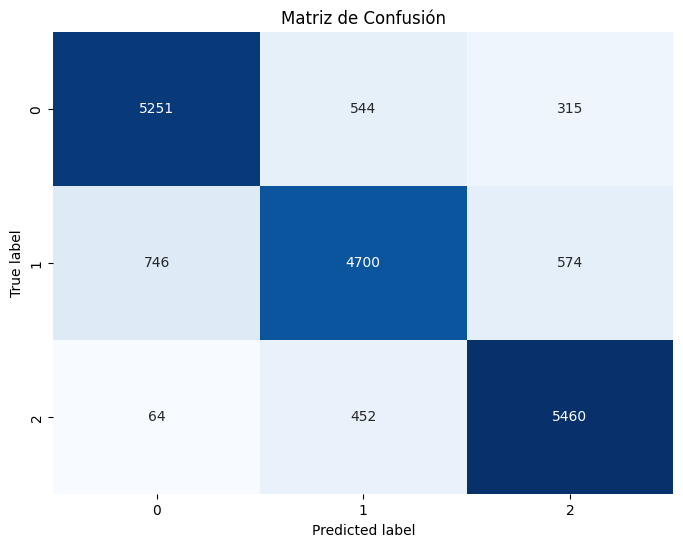

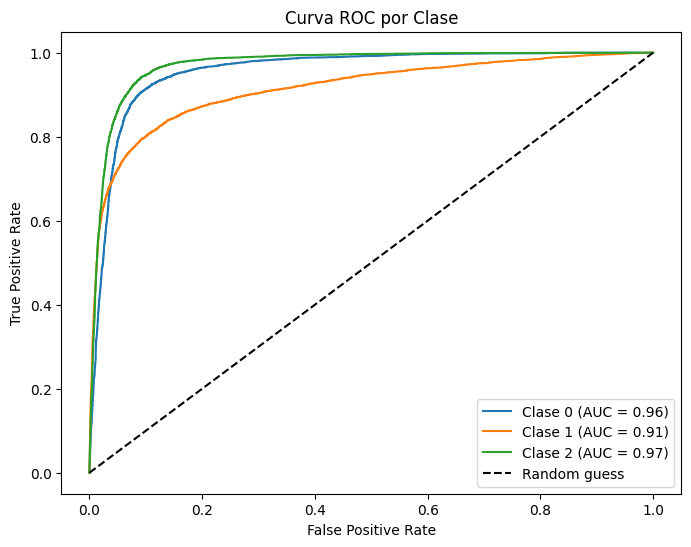

ROC-AUC Macro Promedio: 0.9473
ROC-AUC Weighted Promedio: 0.9473


In [38]:

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Matriz de Confusión")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binarized.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.title("Curva ROC por Clase")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
roc_auc_macro = roc_auc_score(y_test_binarized, y_proba, average="macro")
roc_auc_weighted = roc_auc_score(y_test_binarized, y_proba, average="weighted")
print(f"ROC-AUC Macro Promedio: {roc_auc_macro:.4f}")
print(f"ROC-AUC Weighted Promedio: {roc_auc_weighted:.4f}")

Podemos ver que logramos que el data set tuviese un buen desempenio en cuanto a precision, determinando que mas del 85% de las instancias pueden ser tomadas como correctas en cuanto a prediccion, mientras que el equilibrio de clases se logro debido a el balanceo que se le hizo al data set utilzando SMOTE, lo que a la vez aumento la precision global del modelo, por ultimo es importante mencionar que la curva roc auc nos permite ver que el modelo puede distinguir bastante bien entre las clases.

### Con ello podemos guardar el modelo y dar por concluido el proyecto como un exito :)

In [42]:

directorio = os.path.join('..', '..', 'models')
modelo = 'Prediccion_score_c_rf.pkl'
ruta = os.path.join(directorio, modelo)

joblib.dump(pipeline, ruta)
print(f"Modelo guardado como {ruta}")


Modelo guardado como ..\..\models\Prediccion_score_c_rf.pkl
